Nama : Suwandi Ramadhan
# ===========================================================================
##                      PROJECT 3 : VOICE RECOGNITION
##              Klasifikasi Maksud Ucapan (Intent Classification)
# ===========================================================================

### Data dan Algoritma Understanding

#### TUJUAN :
Membangun model yang dapat mengenali dan
mengklasifikasikan maksud (intent) dari sebuah rekaman suara.

#### DATASET:
https://huggingface.co/datasets/PolyAI/minds14

#### MODEL :
`Fine Tuning` model pre-trained Wav2Vec2
1. facebook/wav2vec2-base
2. facebook/wav2vec2-large-960h
3. jonatasgrosman/wav2vec2-large-xlsr-53-english

### Model Training & Evaluation

In [1]:
import os
import random
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from IPython.display import Audio, display
from tqdm import tqdm

# untuk data dan model
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import  Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Fungsi untuk hasil yang reproducible
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

C:\Users\SUWAAAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load dataset
print('Sedang memuat dataset PolyAI/minds14...')
dataset = load_dataset('PolyAI/minds14', 'en-US', split='train')

df = pd.DataFrame(dataset)
print(f'Dataset berhasil dimuat dengan : \n{len(df)} baris dan {len(df.columns)} kolom.')

df['path'] = df['path'].apply(os.path.abspath)
print(f'\nDataset berhasil dimuat ke dalam DataFrame')

intent_names = dataset.features['intent_class'].names
print(f'Jumlah kelas intent : {len(intent_names)}')

Sedang memuat dataset PolyAI/minds14...
Dataset berhasil dimuat dengan : 
563 baris dan 6 kolom.

Dataset berhasil dimuat ke dalam DataFrame
Jumlah kelas intent : 14


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 563 entries, 0 to 562
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   path                   563 non-null    object
 1   audio                  563 non-null    object
 2   transcription          563 non-null    object
 3   english_transcription  563 non-null    object
 4   intent_class           563 non-null    int64 
 5   lang_id                563 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 26.5+ KB


In [4]:
df.head()

,path,audio,transcription,english_transcription,intent_class,lang_id
0,C:\Users\SUWAAAN\.cache\huggingface\datasets\d...,{'path': 'C:\Users\SUWAAAN\.cache\huggingface\...,I would like to set up a joint account with my...,I would like to set up a joint account with my...,11,4
1,C:\Users\SUWAAAN\.cache\huggingface\datasets\d...,{'path': 'C:\Users\SUWAAAN\.cache\huggingface\...,Henry County set up a joint account with my wi...,Henry County set up a joint account with my wi...,11,4
2,C:\Users\SUWAAAN\.cache\huggingface\datasets\d...,{'path': 'C:\Users\SUWAAAN\.cache\huggingface\...,hi I'd like to set up a joint account with my ...,hi I'd like to set up a joint account with my ...,11,4
3,C:\Users\SUWAAAN\.cache\huggingface\datasets\d...,{'path': 'C:\Users\SUWAAAN\.cache\huggingface\...,how do I start a joint account,how do I start a joint account,11,4
4,C:\Users\SUWAAAN\.cache\huggingface\datasets\d...,{'path': 'C:\Users\SUWAAAN\.cache\huggingface\...,can you help me set up a joint bank account,can you help me set up a joint bank account,11,4


C:\Users\SUWAAAN\AppData\Local\Temp\ipykernel_25584\1990622209.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, y='intent_name', order=df['intent_name'].value_counts().index, palette='viridis')


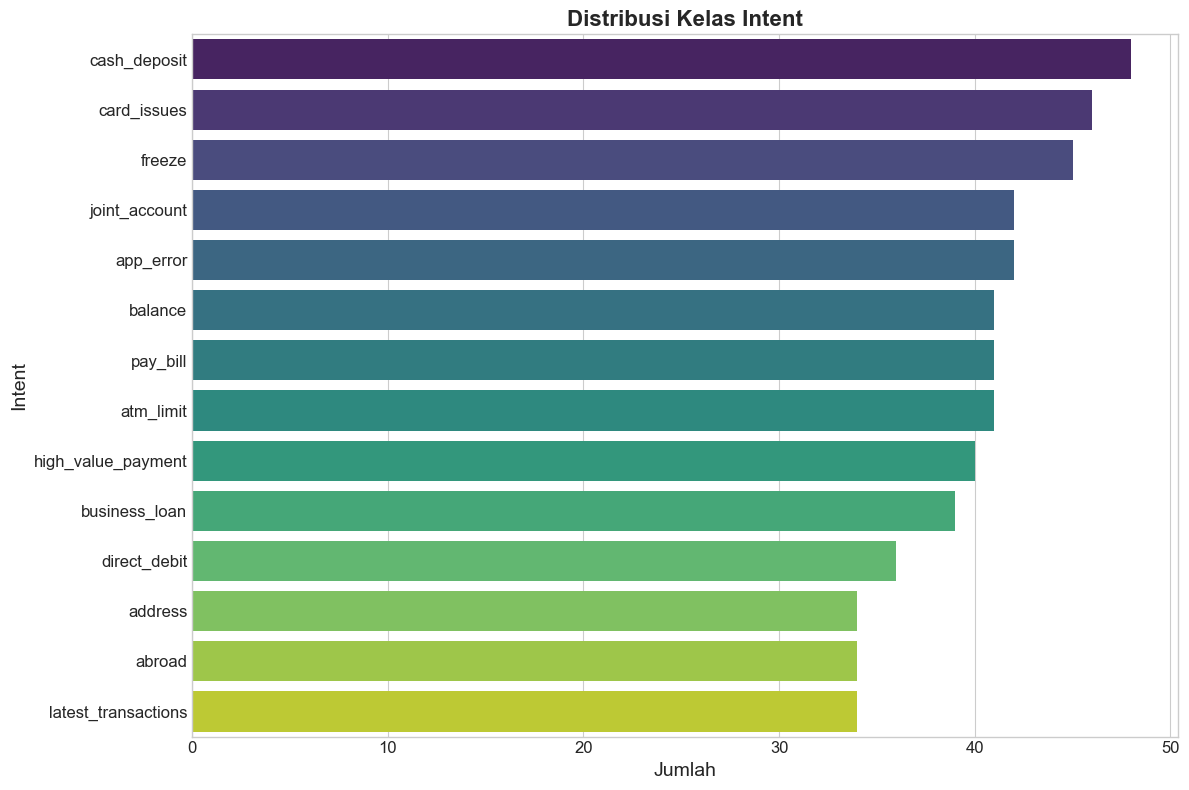

In [5]:
df['intent_name'] = df['intent_class'].apply(lambda x: intent_names[x])

plt.style.use('seaborn-v0_8-whitegrid')
plt.figure(figsize=(12, 8))

sns.countplot(data=df, y='intent_name', order=df['intent_name'].value_counts().index, palette='viridis')
plt.title('Distribusi Kelas Intent', fontdict={'fontsize': 16, 'fontweight': 'bold'})
plt.xlabel('Jumlah', fontdict={'fontsize': 14})
plt.ylabel('Intent', fontdict={'fontsize': 14})
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.show()

Intent : pay_bill
Transcript : hello I'm calling to pay for my electric and water bill or can I make this payment


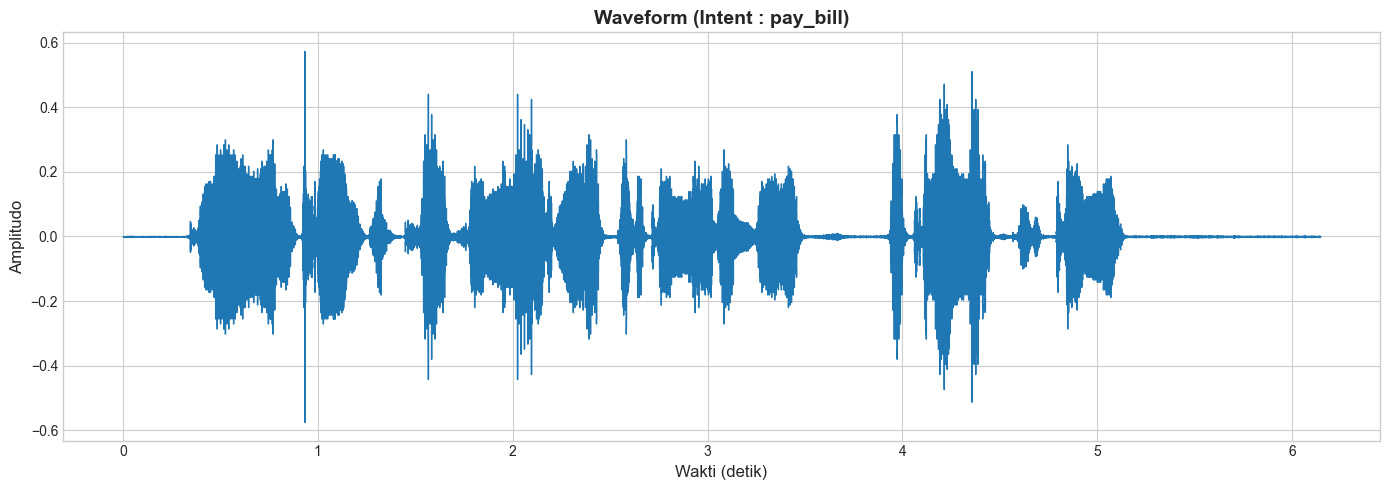

Audio berdasarkan transkript :


In [6]:
random_index = random.randint(0, len(df) - 1)
sample = df.iloc[random_index]

audio_path = sample['path']
intent_label = sample['intent_name']
transcription = sample['transcription']

print(f'Intent : {intent_label}')
print(f'Transcript : {transcription}')

audio_array, sr = librosa.load(audio_path, sr=None, res_type='kaiser_fast')
# Buat Plot
plt.figure(figsize=(14, 5))
ax = plt.subplot(1, 1, 1)
librosa.display.waveshow(audio_array, sr=sr, ax=ax)
plt.title(f'Waveform (Intent : {intent_label})', fontdict={'fontsize': 14, 'fontweight': 'bold'})
plt.xlabel('Wakti (detik)', fontsize=12)
plt.ylabel('Amplitudo', fontsize=12)

plt.tight_layout()
plt.show()

print(f'Audio berdasarkan transkript :')
display(Audio(data=audio_array, rate=sr))

In [7]:
!pip install resampy

In [8]:
# Ekstraksi Fitur
def extract_features(file_path):
    audio, sr = librosa.load(file_path, res_type='kaiser_fast')
    mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40)
    return mfccs

# Terapkan fungsi ekstraksi ke setiap file audio
features = [extract_features(path) for path in tqdm(df['path'])]

max_pad_len = max([feature.shape[1] for feature in features if feature is not None])
print(f'Panjang padding maks : {max_pad_len}')

# Lakukan padding pada fitur MFCC
def pad_features(mfccs, pad_len):
    if mfccs.shape[1] < pad_len:
        pad_width = pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        mfccs = mfccs[:, :pad_len]
    return mfccs

# Terapkan fungsi padding ke semua fitur MFCC
padded_features = [pad_features(f, max_pad_len) for f in tqdm(features) if f is not None]

X = np.array(padded_features)

# Transpose X agar bisa dibaca LSTM
X = X.transpose(0, 2, 1)    # (n_sample, timesteps, n_features)

print(f'Shape data fitur (X) : {X.shape}')

100%|██████████| 563/563 [00:34<00:00, 16.36it/s]


Panjang padding maks : 2518


100%|██████████| 563/563 [00:00<00:00, 3582.48it/s]


Shape data fitur (X) : (563, 2518, 40)


In [9]:
# Encod label dan Pembagian dataset

y = df['intent_class'].values

# Buat dan latih LabelEncoder
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Konversi ke one hot encoding
y_categorical = to_categorical(y_encoded)
num_classes = len(label_encoder.classes_)
print(f'Label diubah ke format one-hot encoding \nShape data label (y) : {y_categorical.shape}')

# Bagi dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)

print(f'Jumlah data train : {X_train.shape}')
print(f'Jumlah data test : {X_test.shape}')

Label diubah ke format one-hot encoding 
Shape data label (y) : (563, 14)
Jumlah data train : (450, 2518, 40)
Jumlah data test : (113, 2518, 40)


In [10]:
# Arsitektur model LSTM
input_shape = (X_train.shape[1], X_train.shape[2])

model = Sequential ([
    Input(shape=input_shape),
    LSTM(128, return_sequences=True,),          # return_sequences=True jika ada LSTM layer berikutnya
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')   # Lapisan output dengan aktivasi softmax untuk klasifikasi multi-kelas
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 2518, 128)      │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2518, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 14)             │           910 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 141,006 (550.80 KB)

 Trainable params: 141,006 (550.80 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
# Kompilasi model
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Parameter training
epoch = 100
batch_size = 32
callback = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

# Latih model
print(f'\nMemulai training model...')
history = model.fit(
    X_train,
    y_train,
    epochs=epoch,
    batch_size=batch_size,
    validation_data=(X_test, y_test),
    callbacks=callback,
    verbose=1
)

print(f'Training selesai.')

model_dir = '../model'
best_model_path = os.path.join(model_dir, 'voice_intent_model_best.h5')

with open(os.path.join(model_dir, 'label_encoder.pkl'), 'wb') as f:
    pickle.dump(label_encoder, f)

print(f'\nModel terbaik telah disimpan di : {best_model_path}')
print(f"\nLabel Encoder telah disinpan di : '{os.path.join(model_dir, 'label_encoder.pkl')}'")


Memulai training model...
Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 45s 3s/step - accuracy: 0.0906 - loss: 2.6391 - val_accuracy: 0.0796 - val_loss: 2.6364
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 43s 3s/step - accuracy: 0.0887 - loss: 2.6388 - val_accuracy: 0.0708 - val_loss: 2.6354
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.0490 - loss: 2.6473 - val_accuracy: 0.0885 - val_loss: 2.6354
Epoch 4/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.0774 - loss: 2.6404 - val_accuracy: 0.0885 - val_loss: 2.6348
Epoch 5/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.0727 - loss: 2.6394 - val_accuracy: 0.0885 - val_loss: 2.6345
Epoch 6/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - accuracy: 0.0739 - loss: 2.6405 - val_accuracy: 0.0885 - val_loss: 2.6348
Epoch 7/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.0666 - loss: 2.6411 - val_accuracy: 0.0885 - val_loss: 2.6347
Epoch 8/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.0770 - loss: 2.6397

In [12]:
# Evaluasi Model Hasil Training
loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f'\nHasil Evaluasi :')
print(f'Akurasi : {accuracy*100:.2f}%')
print(f'Loss : {loss:.4f}')


Hasil Evaluasi :
Akurasi : 8.85%
Loss : 2.6341


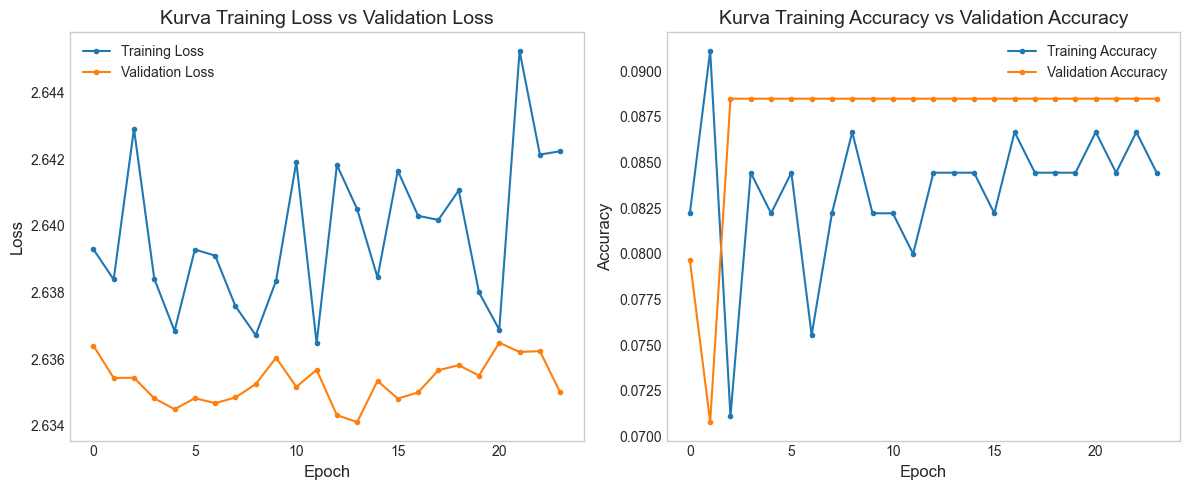

In [13]:
# Visualisasi hasil training
history_training = pd.DataFrame(history.history)

plt.figure(figsize=(12, 5))

# Training Loss vs Validation Loss
plt.subplot(1, 2, 1)
plt.plot(history_training['loss'], label='Training Loss', marker='.')
plt.plot(history_training['val_loss'], label='Validation Loss', marker='.')
plt.title(f'Kurva Training Loss vs Validation Loss', fontdict={'fontsize': 14})
plt.xlabel('Epoch', fontdict={'fontsize': 12})
plt.ylabel('Loss', fontdict={'fontsize': 12})
plt.legend()
plt.grid()


# Training Accuracy vs Validation Accuracy
plt.subplot(1, 2, 2)
plt.plot(history_training['accuracy'], label='Training Accuracy', marker='.')
plt.plot(history_training['val_accuracy'], label='Validation Accuracy', marker='.')
plt.title(f'Kurva Training Accuracy vs Validation Accuracy', fontdict={'fontsize': 14})
plt.xlabel('Epoch', fontdict={'fontsize': 12})
plt.ylabel('Accuracy', fontdict={'fontsize': 12})
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

Prediksi pada data test untuk analisis
4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 668ms/step

==== Classification Report ====

                     precision    recall  f1-score   support

             abroad       0.00      0.00      0.00         7
            address       0.00      0.00      0.00         7
          app_error       0.00      0.00      0.00         8
          atm_limit       0.00      0.00      0.00         8
            balance       0.00      0.00      0.00         8
      business_loan       0.00      0.00      0.00         8
        card_issues       0.00      0.00      0.00         9
       cash_deposit       0.09      1.00      0.16        10
       direct_debit       0.00      0.00      0.00         7
             freeze       0.00      0.00      0.00         9
 high_value_payment       0.00      0.00      0.00         8
      joint_account       0.00      0.00      0.00         9
latest_transactions       0.00      0.00      0.00         7
           pay_bill       0.00   

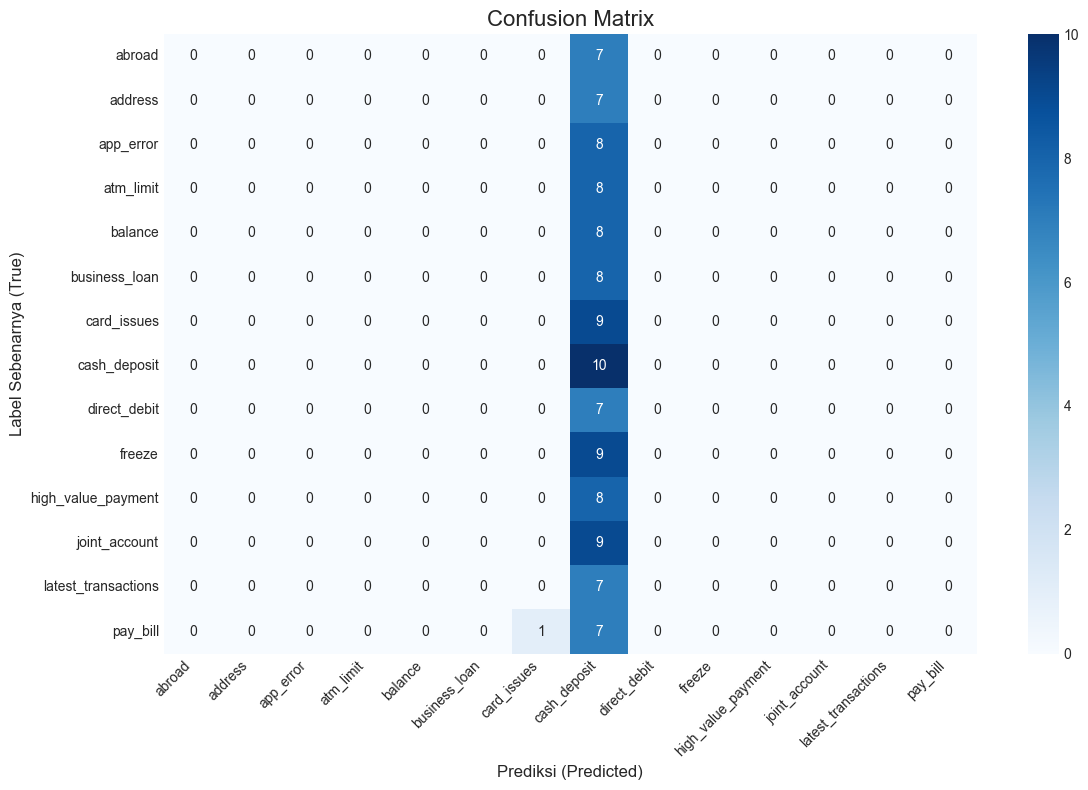

In [14]:
print(f'Prediksi pada data test untuk analisis')
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

target_names = label_encoder.classes_
target_names_str = [intent_names[i] for i in target_names]

print(f'\n==== Classification Report ====\n')
report = classification_report(y_true, y_pred, target_names=target_names_str, zero_division=0)
print(report)

print(f'\n==== Confusion Matrix ====\n')
cm = confusion_matrix(y_true, y_pred)

# Visualisasi heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names_str, yticklabels=target_names_str)
plt.title('Confusion Matrix', fontdict={'fontsize': 16})
plt.ylabel('Label Sebenarnya (True)', fontsize=12)
plt.xlabel('Prediksi (Predicted)', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

plt.tight_layout()
plt.show()